---
title: "Network Creation"
---

## Import Required Libraries

In [1]:
import pandas as pd
import networkx as nx
from itertools import combinations
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
import json

## Load Dataframe

In [2]:
df = pd.read_csv("../data/processed/cleaned_movies.csv")

# Create Person Features

In [3]:
def build_person_features(df):
    person_stats = defaultdict(list)

    for _, row in df.iterrows():
        collaborators = row["Actors"] + row["Directors"] + row["Producers"] + row["Writers"] + row["Composers"]
        for person in collaborators:
            person_stats[person].append({
                "rating": row["Average_Rating"],
                "roi": row["Return_On_Investment"],
                "revenue": row["Revenue_Normalized"],
                "budget": row["Budget_Normalized"]
            })

    person_features = {}
    for person, records in person_stats.items():
        n = len(records)
        person_features[person] = {
            "avg_rating": sum(r["rating"] for r in records) / n,
            "avg_roi": sum(r["roi"] for r in records) / n,
            "avg_revenue": sum(r["revenue"] for r in records) / n,
            "avg_budget": sum(r["budget"] for r in records) / n
        }

    return person_features


## Actor/Director Collaboration Graph (Heterogeneous Graph)

Network Architecture:
- Nodes: Actors + directors
- Edges: Collaborations between them (if they worked on the same movie)

In [4]:
# Create heterogeneous graph of actors + directors with collaboration edges
def create_crew_collaboration_network(df, save_path):
    # Create empty graph
    G = nx.Graph()

    # Convert stringified lists into actual Python lists
    for col in ["Actors", "Directors", "Producers", "Writers", "Composers"]:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    person_features = build_person_features(df)

    # Iterate through rows in df
    for _, row in df.iterrows():
        # Track movie titles
        movie_title = row["Title"]

        year = row["Year"]

        if isinstance(row["Genre"], str):
            genres = row["Genre"].split(";")  
        else:
            genres = []

        # Add actor nodes
        for actor in row["Actors"]:
            if not G.has_node(actor):
                G.add_node(actor, type = "actor", **person_features.get(actor, {}))
        
        # Add director nodes
        for director in row["Directors"]:
            if not G.has_node(director):
                G.add_node(director, type = "director", **person_features.get(director, {}))

        # Combine actors and directors as nodes in this movie
        collaborators = row["Actors"] + row["Directors"]
        
        # Add edges for all pairs of collaborators in this movie (undirected)
        for person_1, person_2 in combinations(collaborators, 2):
            if G.has_edge(person_1, person_2):
                # Append movie to the existing list of common movies
                G[person_1][person_2]["common_movies"].append(movie_title)

                # Increase collaboration weight if edge exists
                G[person_1][person_2]["weight"] += 1
                
                # Append year to existing attributes
                G[person_1][person_2]["years"].append(year)

                # Append genres to existing attributes
                G[person_1][person_2]["genres"].update(genres)

                # Append movie stats to existing attributes
                G[person_1][person_2]["movie_stats"].append({
                    "title": movie_title,
                    "year": year,
                    "avg_rating": row["Average_Rating"],
                    "roi": row["Return_On_Investment"],
                    "revenue": row["Revenue_Normalized"],
                    "budget": row["Budget_Normalized"],
                    "oscar_wins": row["Oscar_Wins"],
                    "oscar_noms": row["Oscar_Nominations"],
                    "won_award": row["Won_Award"],
                    "genres": genres
                })

            else:
                G.add_edge(person_1, 
                           person_2, 
                           weight = 1, 
                           common_movies = [movie_title],
                           movie_stats = [{
                                "title": movie_title,
                                "year": year,
                                "avg_rating": row["Average_Rating"],
                                "roi": row["Return_On_Investment"],
                                "revenue": row["Revenue_Normalized"],
                                "budget": row["Budget_Normalized"],
                                "oscar_wins": row["Oscar_Wins"],
                                "oscar_noms": row["Oscar_Nominations"],
                                "won_award": row["Won_Award"],
                                "genres": genres
                            }],
                           years = [year],
                           genres = set(genres))

    # Convert list attributes in nodes to strings
    for node, data in G.nodes(data = True):
        for key in list(data.keys()):
            if isinstance(data[key], list) or isinstance(data[key], set):
                data[key] = ";".join(map(str, data[key]))

    # Convert list/set attributes in edges to strings, serialize complex structures properly
    for u, v, data in G.edges(data = True):
        for key in list(data.keys()):
            if key == "movie_stats":
                data[key] = json.dumps(data[key])  # Proper JSON serialization
            elif isinstance(data[key], (list, set)):
                data[key] = ";".join(map(str, data[key]))

    # Save graph to GraphML format
    if save_path is not None:
        nx.write_graphml(G, f"{save_path}crew_collaboration_network.graphml")
    else:
        pass

    return G

In [ ]:
df_sample = df.sample(n = 50, random_state = 777).copy()
df_sample = df[0:201].copy()
save_path = "../data/networks/"

G = create_crew_collaboration_network(df, save_path)

## Movie Similarity Graph

Network Architecture:
- Nodes: Movies
- Edges: Movies sharing at least one actor or director.

In [5]:
# Create movie similarity graph based on shared actors/directors
def create_movie_similarity_network(df, save_path):
    # Create empty graph
    G = nx.Graph()

    df["Actors"] = df["Actors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df["Directors"] = df["Directors"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Add movie nodes with some attributes
    for index, row in df.iterrows():
        movie_id = row["Title"]
        G.add_node(movie_id, 
            year = row["Year"],
            metascore_rating = row["Metascore_Rating"],
            imdb_rating = row["IMDB_Rating"],
            rotten_tomatoes_rating = row["Rotten_Tomatoes_Rating"],
            tmdb_rating = row["TMDB_Rating"],
            avg_rating = row["Average_Rating"],
            budget = row["Budget_Normalized"],
            revenue = row["Revenue_Normalized"],
            roi = row["Return_On_Investment"],
            runtime = row["Runtime"],
            genre = row["Genre"],
            won_award = row["Won_Award"],
            oscar_wins = row["Oscar_Wins"],
            oscar_noms = row["Oscar_Nominations"],
            popularity = row["Popularity"],
            age_rating = row["Age_Rating"],
            directors = ";".join(row["Directors"]) if isinstance(row["Directors"], list) else row["Directors"]
        )

    # Build a dict: person -> set of movies they worked on
    person_to_movies = defaultdict(set)
    movie_meta = df.set_index("Title")

    for _, row in df.iterrows():
        movie_id = row["Title"]
        collaborators = row["Actors"] + row["Directors"]

        for person in collaborators:
            person_to_movies[person].add(movie_id)

    # For each person, connect all movies they worked on
    for person, movies in person_to_movies.items():
        for movie_1, movie_2 in combinations(movies, 2):
            # Increase collaboration weight if edge exists
            if G.has_edge(movie_1, movie_2):
                # Append this person to the list of common collaborators on the edge
                G[movie_1][movie_2]["common_crew"].append(person)
                
                # Increase collaboration weight if edge exists
                G[movie_1][movie_2]["weight"] += 1

            else:
                genre_1 = set(movie_meta.loc[movie_1]["Genre"].split(";")) if isinstance(movie_meta.loc[movie_1]["Genre"], str) else set()
                genre_2 = set(movie_meta.loc[movie_2]["Genre"].split(";")) if isinstance(movie_meta.loc[movie_2]["Genre"], str) else set()
                shared_genres = genre_1 & genre_2

                G.add_edge(
                    movie_1,
                    movie_2,
                    weight = 1,
                    common_crew = [person],
                    shared_genres = ";".join(shared_genres)
                )

    # For each edge, convert list attributes to strings
    for u, v, data in G.edges(data = True):
        if isinstance(data["common_crew"], list):
            data["common_crew"] = ";".join(data["common_crew"])

    # Save graph to GraphML format
    if save_path is not None:
        nx.write_graphml(G, f"{save_path}movie_similarity_network_all_ratings.graphml")
    else:
        pass

    return G

In [10]:
df_sample = df.sample(n = 50, random_state = 777).copy()
df_sample = df[0:201].copy()
save_path = "../data/networks/"

G = create_movie_similarity_network(df, save_path)

## Visualize the Networks

### Crew Collaboration Network

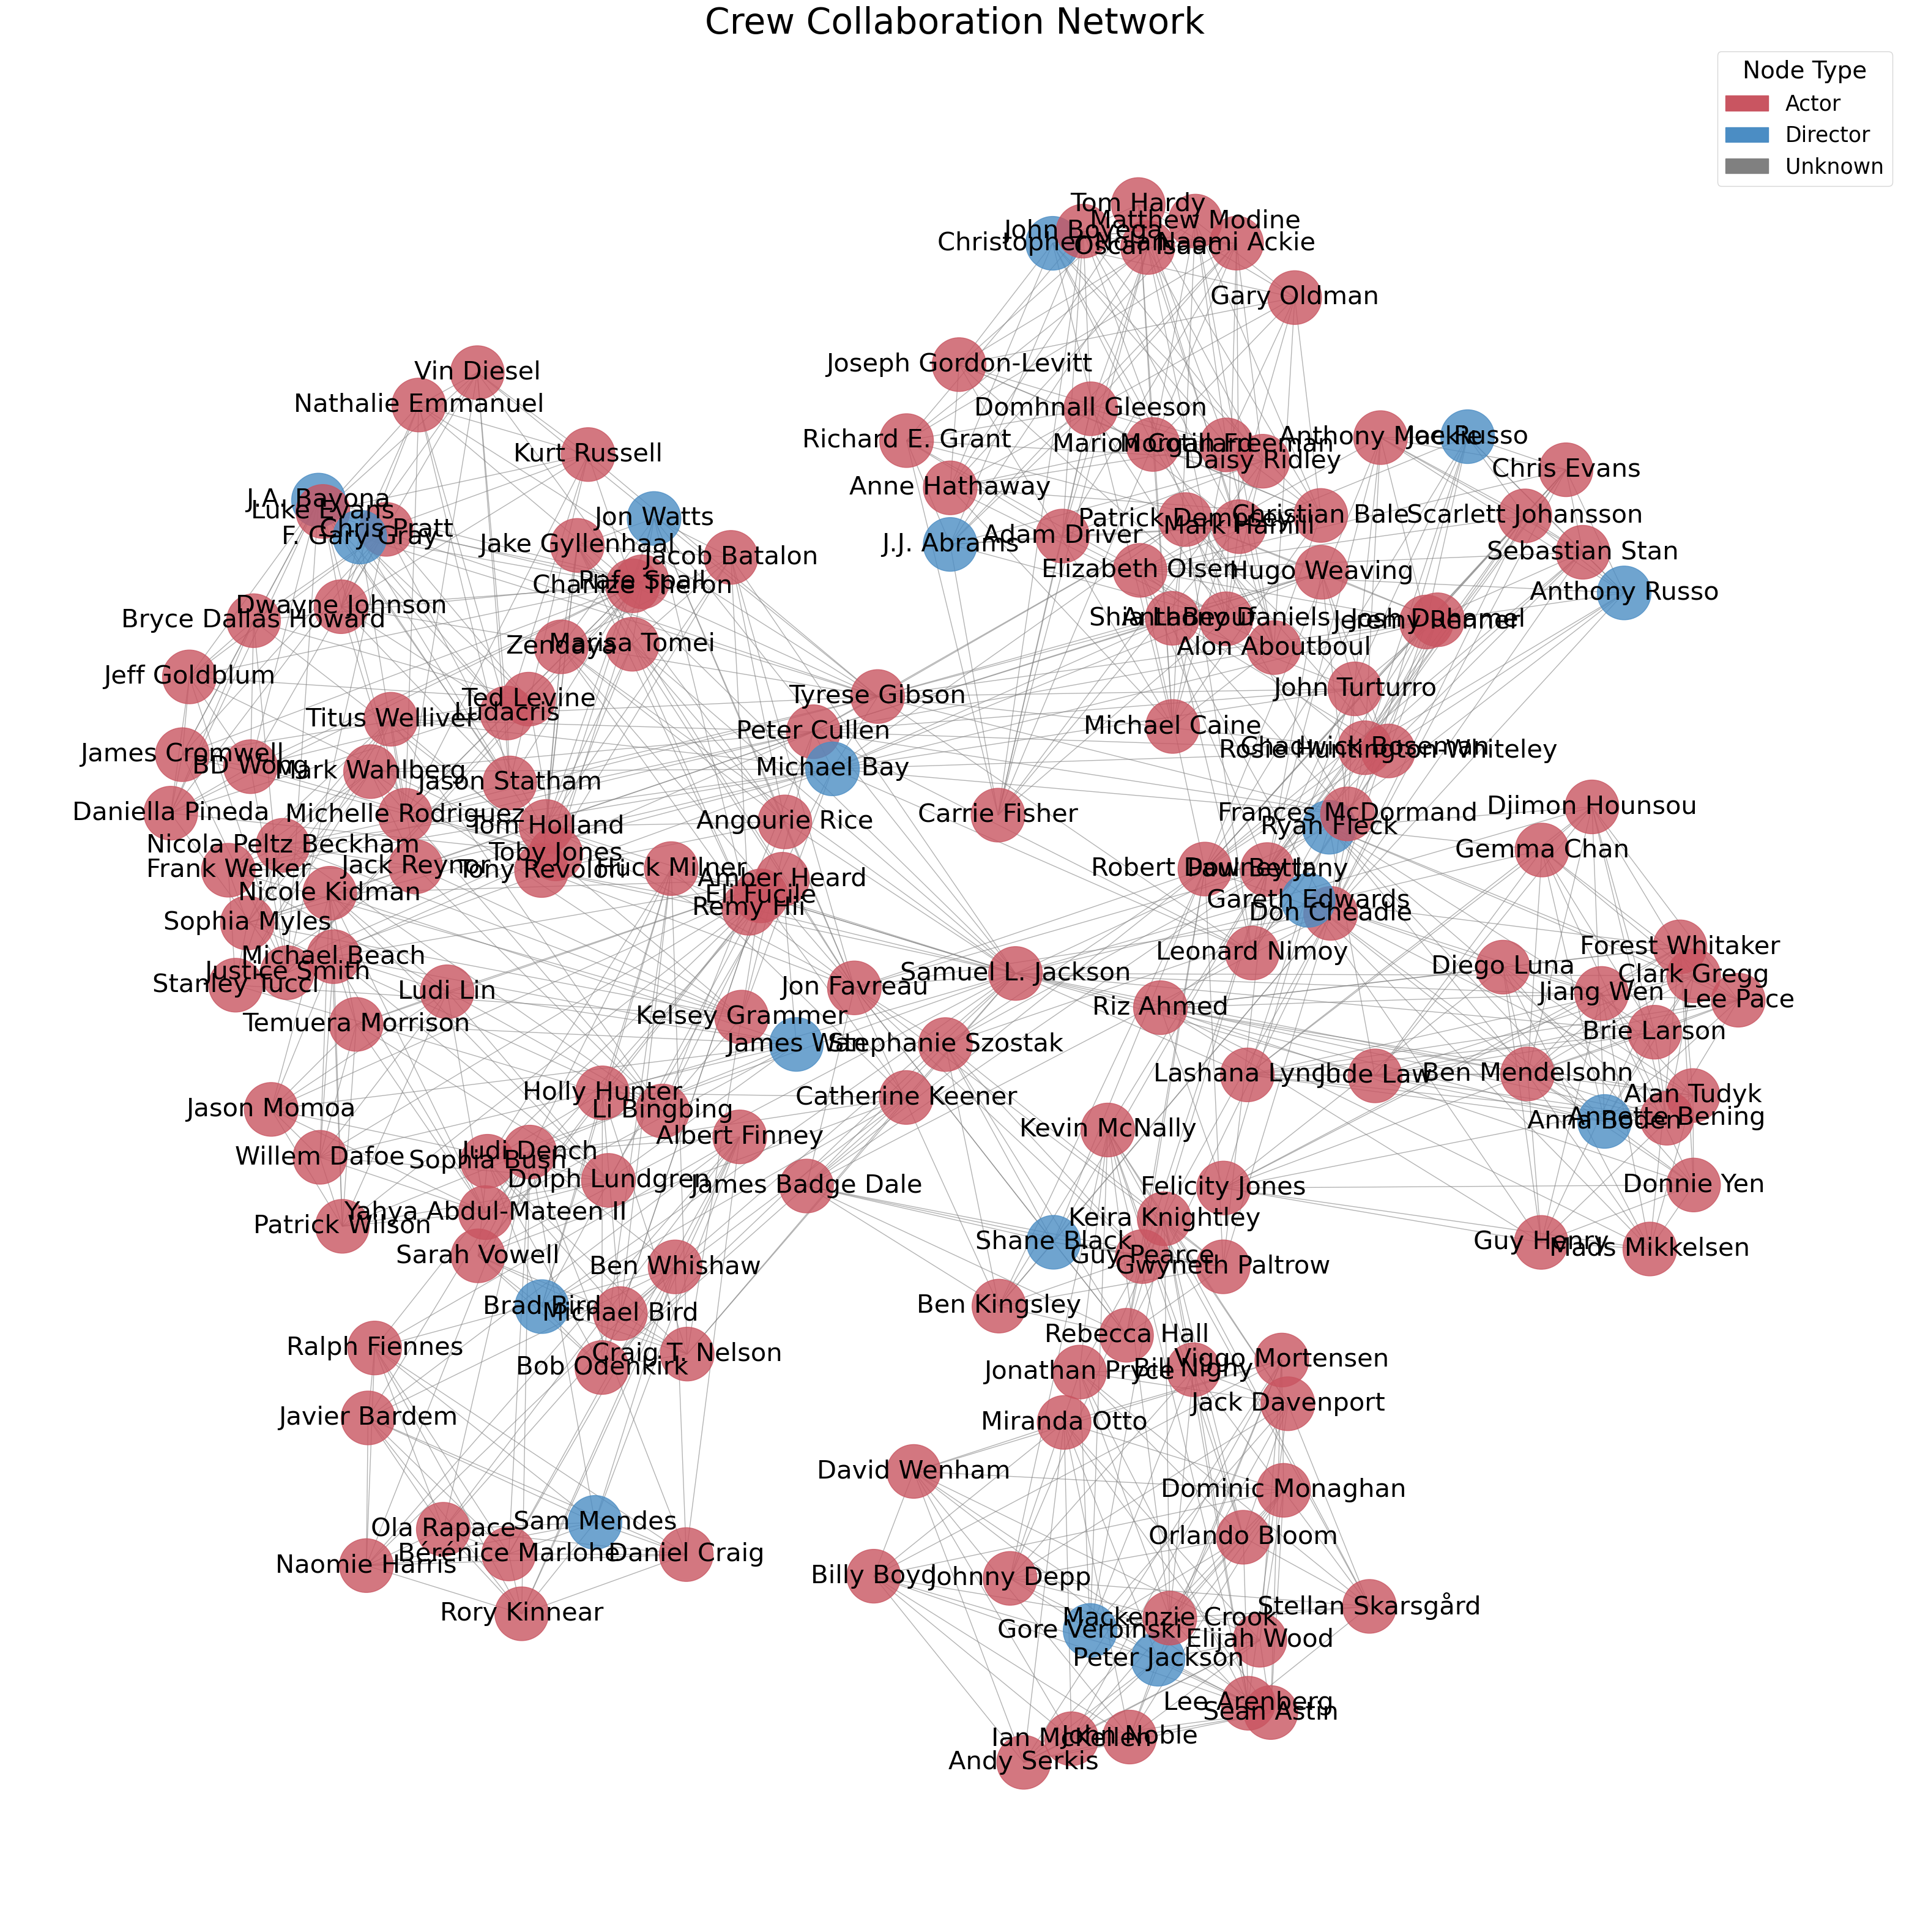

In [33]:
#G = nx.read_graphml("../data/networks/crew_collaboration_network.graphml")

df_sample = df[15:31].copy()
save_path = None

G = create_crew_collaboration_network(df_sample, save_path)

import matplotlib.patches as mpatches

# Create legend handles
actor_patch = mpatches.Patch(color = "#C95561", label = "Actor")
director_patch = mpatches.Patch(color = "#4B8DC4", label = "Director")
unknown_patch = mpatches.Patch(color = "gray", label = "Unknown")


# Convert selected edge attributes back to lists
for u, v, data in G.edges(data = True):
    if "common_movies" in data and isinstance(data["common_movies"], str):
        data["common_movies"] = data["common_movies"].split(";")
    if "years" in data and isinstance(data["years"], str):
        data["years"] = [
            int(float(year)) for year in data["years"].split(";")
            if year.lower() != "nan" and year.strip() != ""
        ]
    if "genres" in data and isinstance(data["genres"], str):
        data["genres"] = data["genres"].split(";")

# Convert selected node attributes
for node, data in G.nodes(data = True):
    if "genres" in data and isinstance(data["genres"], str):
        data["genres"] = data["genres"].split(";")

# Color nodes by type attribute
color_map = []
for node in G.nodes():
    node_type = G.nodes[node].get("type", "unknown")
    if node_type == "actor":
        color_map.append("#C95561")
    elif node_type == "director":
        color_map.append("#4B8DC4")
    else:
        color_map.append("gray")


plt.figure(figsize = (40, 40))

pos = nx.spring_layout(G, seed = 3, k = 1.25, iterations = 100, scale = 2)
# pos = nx.circular_layout(G)

nx.draw_networkx_nodes(G, pos, node_color = color_map, alpha = 0.8, node_size = 4000)
nx.draw_networkx_edges(G, pos, alpha = 0.6, edge_color = "gray")
nx.draw_networkx_labels(G, pos, font_size = 30)

plt.title("Crew Collaboration Network", fontsize = 42)
plt.legend(handles = [actor_patch, director_patch, unknown_patch], title = "Node Type", fontsize = 25, title_fontsize = 28, loc = "best")

plt.axis("off")
plt.savefig("../assets/crew_collaboration_network.png", format = "png", dpi = 300, bbox_inches = "tight")
plt.show()

### Movie Similarity Network

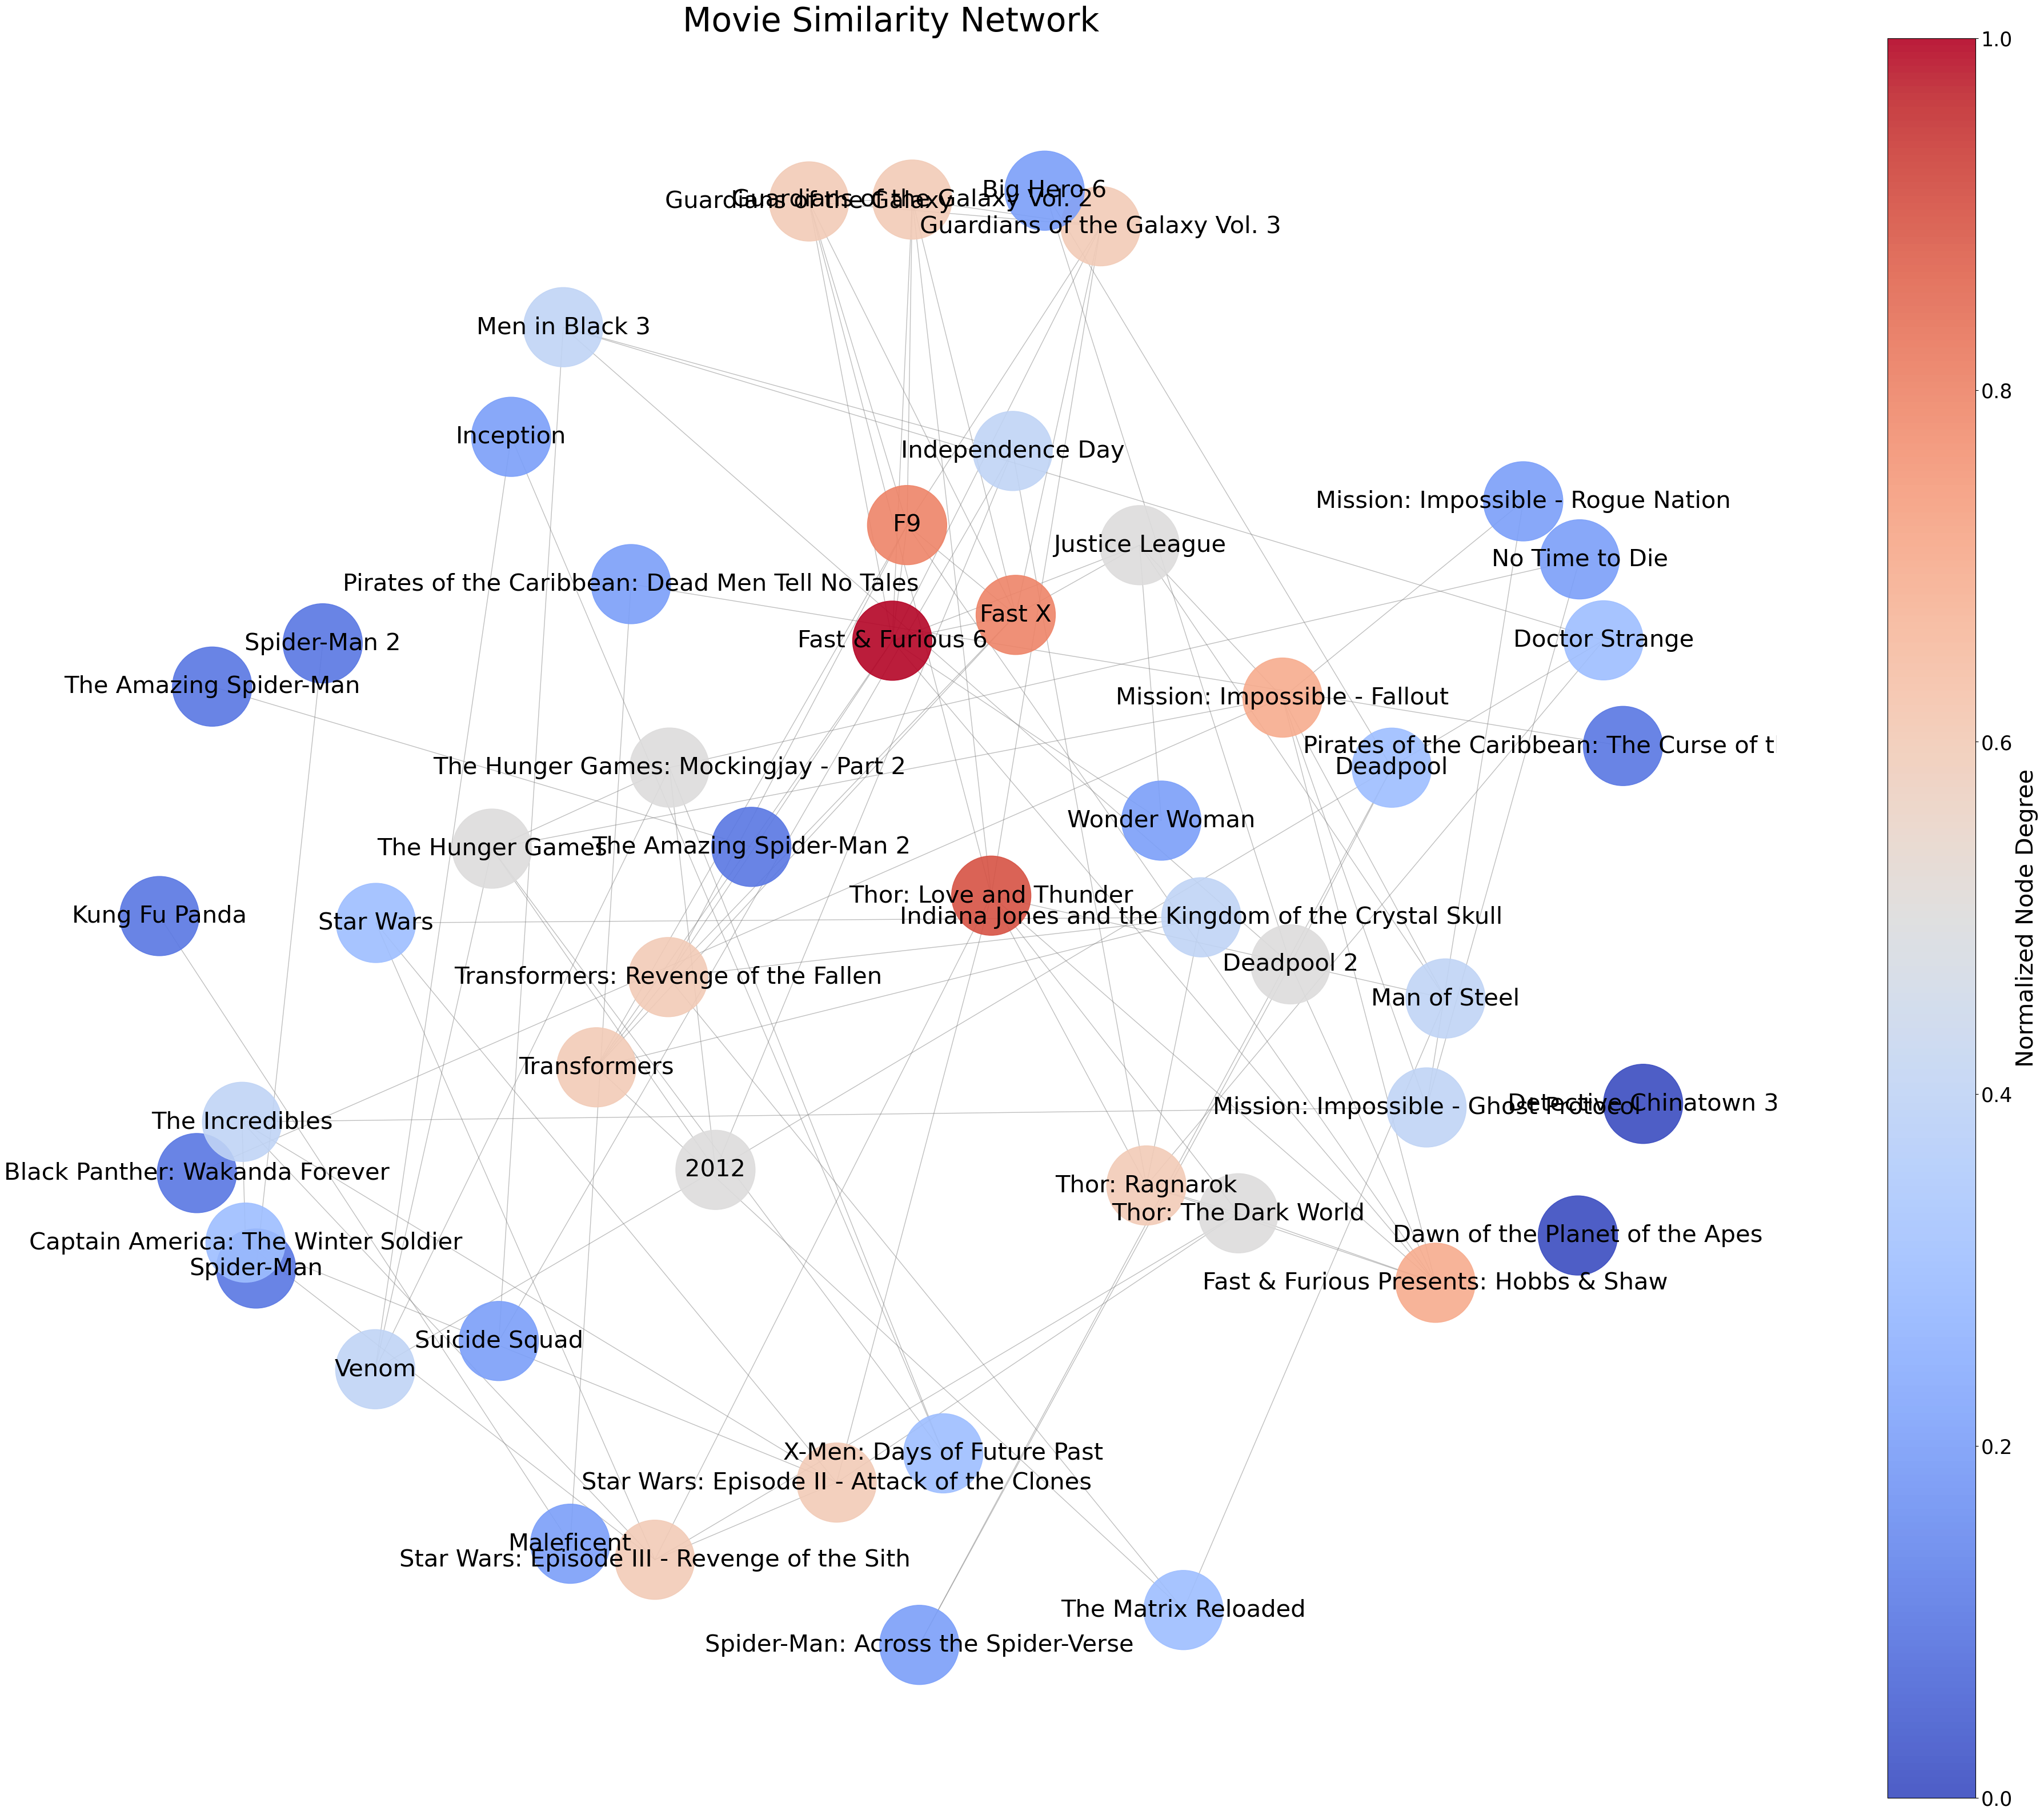

In [14]:
#G = nx.read_graphml("../data/networks/movie_similarity_network.graphml")

df_sample = df[50:101].copy()
save_path = None

G = create_movie_similarity_network(df_sample, save_path)

# Convert common_crew strings back to lists
for u, v, data in G.edges(data = True):
    if "common_crew" in data and isinstance(data["common_crew"], str):
        data["common_crew"] = data["common_crew"].split(";")

# Calculate node degrees
degrees = dict(G.degree())
degree_values = list(degrees.values())

# Normalize degrees for coloring (optional)
max_degree = max(degree_values) if degree_values else 1
node_colors = [degree / max_degree for degree in degree_values]

plt.figure(figsize = (50, 40))

pos = nx.spring_layout(G, seed = 1, k = 5, iterations = 200, scale = 3)
# pos = nx.circular_layout(G)

# Draw nodes with color map (e.g., using a colormap from matplotlib)
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_color = node_colors,
    cmap = plt.cm.coolwarm,
    alpha = 0.9,
    node_size = 10000,
)

nx.draw_networkx_edges(G, pos, alpha = 0.5, edge_color = "gray")
nx.draw_networkx_labels(G, pos, font_size = 30)

cbar = plt.colorbar(nodes)
cbar.set_label("Normalized Node Degree", fontsize = 30)
cbar.ax.tick_params(labelsize = 25)

plt.title("Movie Similarity Network", fontsize = 42)
plt.axis("off")

plt.savefig("../assets/movie_similarity_network.png", format = "png", dpi = 300, bbox_inches = "tight")

plt.show()

## Subgraph Creation - One Subgraph Per Movie Using the Crew Collaboration Network

In [18]:
# Set to none so that the graph is not saved again
save_path = None

G = create_crew_collaboration_network(df, save_path)

# list to hold subgraphs and corresponding labels
movie_graphs = []  
labels = []

for _, row in df.iterrows():
    crew = row["Actors"] + row["Directors"]
    label = row["Revenue_Normalized"]

    # Filter to crew members that exist in G
    crew = [p for p in crew if p in G]
    
    # Extract the subgraph for this movie
    subgraph = G.subgraph(crew).copy()

    # Store metadata as a graph attribute
    subgraph.graph["movie_title"] = row["Title"]
    subgraph.graph["Year"] = row["Year"]
    subgraph.graph["Budget_Normalized"] = row["Budget_Normalized"]
    subgraph.graph["Runtime"] = row["Runtime"]
    subgraph.graph["Age_Rating"] = row["Age_Rating"]
    subgraph.graph["label"] = label

    movie_graphs.append(subgraph)
    labels.append(label)

In [19]:
for idx, sg in enumerate(movie_graphs[:5]):
    print(f"Movie {idx}: {sg.graph['movie_title']}")
    print(f"Label: {sg.graph['label']}")
    print(f"Nodes: {list(sg.nodes())}")
    print(f"Edges: {list(sg.edges(data = True))}")
    print("-----")

Movie 0: Avatar
Label: 15.346272333891148
Nodes: ['Joel David Moore', 'Laz Alonso', 'James Cameron', 'Sam Worthington', 'Giovanni Ribisi', 'Sigourney Weaver', 'Zoe Saldaña', 'Wes Studi', 'CCH Pounder', 'Stephen Lang', 'Michelle Rodriguez']
Edges: [('Joel David Moore', 'Sam Worthington', {'weight': 2, 'common_movies': 'Avatar;Avatar: The Way of Water', 'movie_stats': '[{"title": "Avatar", "year": 2009.0, "avg_rating": 7.975, "roi": 12.336312345991562, "revenue": 15.346272333891148, "budget": 4.6213192937136265, "oscar_wins": 3, "oscar_noms": 0, "won_award": true, "genres": ["[\'Action\', \'Adventure\', \'Fantasy\', \'Science Fiction\']"]}, {"title": "Avatar: The Way of Water", "year": 2022.0, "avg_rating": 7.35, "roi": 5.04402235, "revenue": 12.070590655537387, "budget": 9.55819820283216, "oscar_wins": 1, "oscar_noms": 0, "won_award": true, "genres": ["[\'Science Fiction\', \'Adventure\', \'Action\']"]}]', 'years': '2009.0;2022.0', 'genres': "['Science Fiction', 'Adventure', 'Action'];[

Movie: Top Gun
Year: 1986.0
Age_Rating: PG
Runtime: 109.0
Budget_Normalized: -0.2934211449604303
Label (Normalized Revenue): 1.4127455260735788


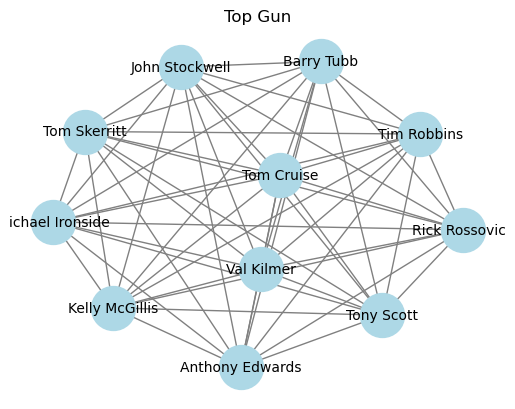

In [20]:
# Example of how to visualize one of the movie subgraphs
movie_index = 247

print("Movie:", movie_graphs[movie_index].graph["movie_title"])
print("Year:", movie_graphs[movie_index].graph["Year"])
print("Age_Rating:", movie_graphs[movie_index].graph["Age_Rating"])
print("Runtime:", movie_graphs[movie_index].graph["Runtime"])
print("Budget_Normalized:", movie_graphs[movie_index].graph["Budget_Normalized"])
print("Label (Normalized Revenue):", movie_graphs[movie_index].graph["label"])


nx.draw_networkx(
    movie_graphs[movie_index],
    with_labels = True,
    node_color = "lightblue",
    edge_color = "gray",
    node_size = 1000,
    font_size = 10
)
plt.title(movie_graphs[movie_index].graph["movie_title"])
plt.axis("off")
plt.show()